In [ ]:
from google.colab import drive
# monta tu unidad de google drive
drive.mount('/content/drive')

# cambiamos el directorio de trabajo a la carpeta donde está almacenado el dataset
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/HomoMex_2024/track2')

Mounted at /content/drive



CNN
Fragmento el dataset en training validacion test

In [ ]:
import pandas as pd

df_train = pd.read_csv("train_track2_75.csv",  sep=',')
df_test = pd.read_csv("test_track2_15.csv",  sep=',')

print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

# mostramos los primeros registros del training:
df_test.head()



tamaño training: (647, 7)
tamaño test: (129, 7)


,content,L,G,B,T,O,NR
0,Ser valiente ponga #Foto y no Sea #Maricon yo...,0,1,0,0,0,0
1,Se verá muy joto el baking? 😂,0,1,0,0,0,0
2,@swisingley Díselo a el transgénero que ganó m...,0,0,0,1,0,0
3,@AlanPonce_29 @Nora_Ruvalcaba @RoyCampos @PGR_...,0,1,0,0,0,0
4,-¿Me da un 12 de Tecate light?\n-¿No quiere un...,0,1,0,0,0,0


In [ ]:
print(df_train)

                                               content  L  G  B  T  O  NR
0    @Gamborimbo76 @ElPincheJuan4 @GorillaMan06 @ce...  0  0  0  0  1   0
1    @Alex_16ec @sopitas @greciaplg Pensé que ya no...  0  1  0  0  0   0
2           @RubenCharvel El maricón es el tal chineo!  0  1  0  0  0   0
3    Manny Pacquiao: “ #Homosexuales son peores que...  0  1  0  0  0   0
4       @danieladurannb Mmmm pues se pasó de mariquita  0  1  0  0  0   0
..                                                 ... .. .. .. .. ..  ..
642  Vecinos! Esta noche proyectaremos con @FESTIVA...  0  0  0  0  1   0
643            @url  Y esperabas tu arcoíris 🌈 marica?  0  1  0  0  0   0
644   @EdgardBeltran @AlexBurruel1 no traen nada jotos  0  1  0  0  0   0
645              Esta Brucita también es mariquita! 💃🏼  0  1  0  0  0   0
646        @poqkeeet Porque Eres Un Vato 🙄 Puta Lencha  1  0  0  0  0   0

[647 rows x 7 columns]


Distribucion de las clases Test

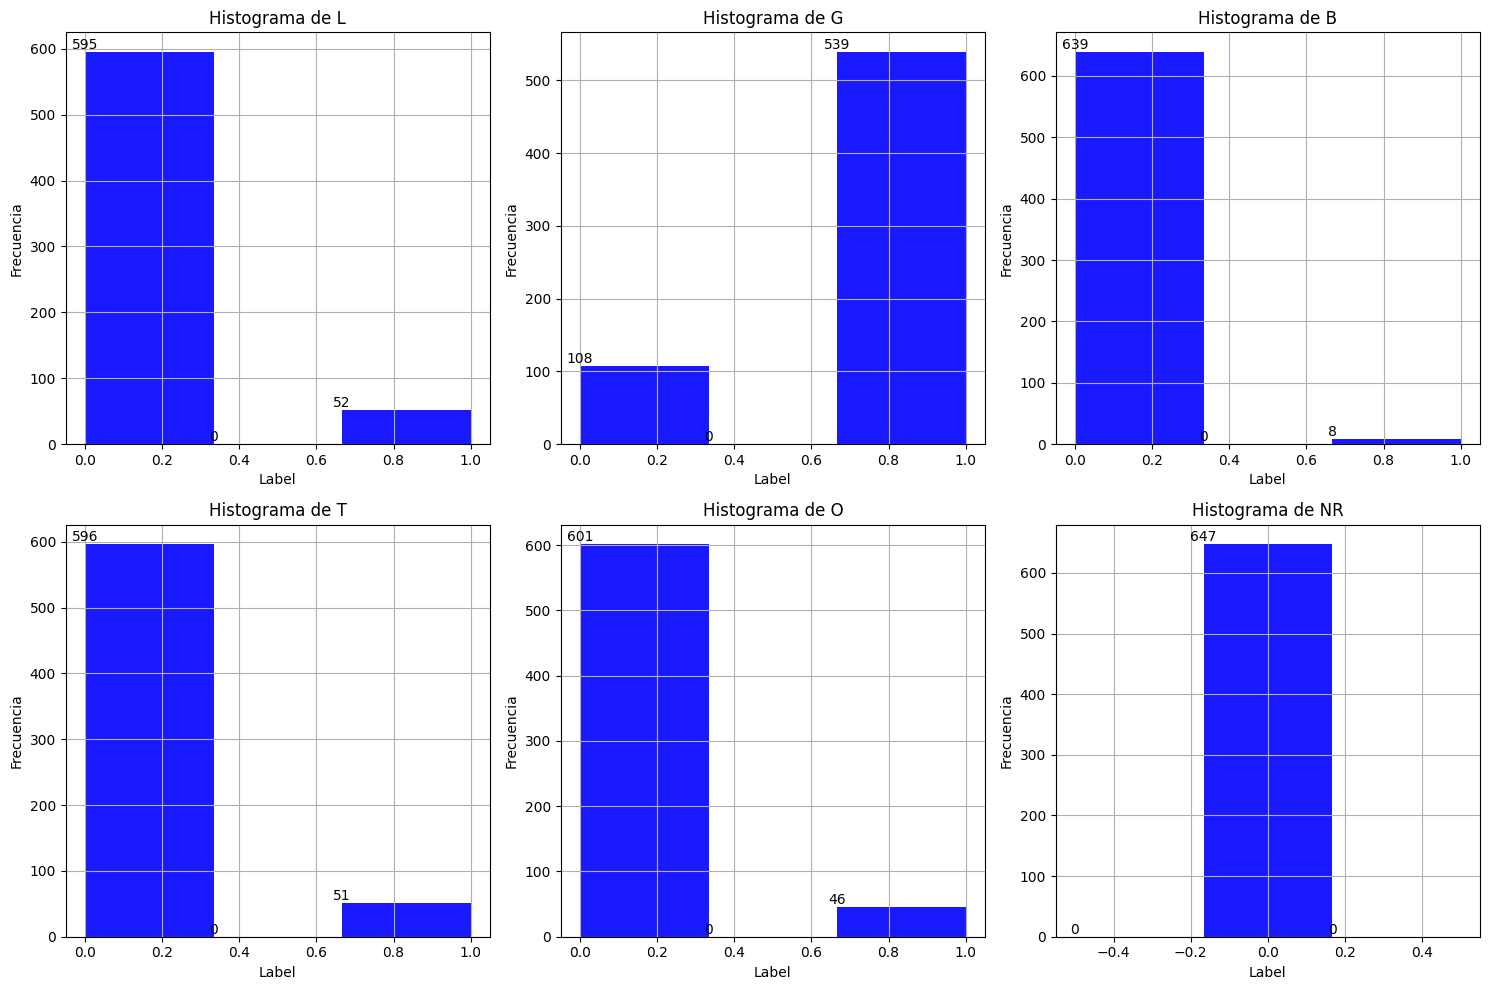

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y subtramas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Clases disponibles
classes = ['L', 'G', 'B', 'T', 'O', 'NR']

# Iterar sobre las clases y crear histogramas en cada subtrama
for i, ax in enumerate(axes.flat):
    if i < len(classes):
        # Seleccionar la clase actual
        current_class = classes[i]

        # Crear histograma para la clase actual
        n, bins, patches = ax.hist(df_train[current_class], bins=3, color='blue', alpha=0.9)
        ax.set_xlabel('Label')
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Histograma de {current_class}')
        ax.grid(True)

        # Agregar los valores de cada bin dentro del gráfico con rotación de 90 grados
        for count, (bin_, patch) in enumerate(zip(bins, patches)):
            ax.text(bin_, n[count], f"{int(n[count])}", ha='center', va='bottom')

# Ajustar el espacio entre subtramas
plt.tight_layout()

# Mostrar la figura



LABEL ENCODING

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# y_train = df_1['label'].tolist()
# y_train = df_2_var1['label'].tolist()
labels = ['L', 'G', 'B', 'T', 'O', 'NR']
# y_train = labels.tolist()



le = LabelEncoder()

print("antes de transform: ", labels[:10])
labels = le.fit_transform(labels)
LABELS = le.classes_
NUM_LABELS = len(LABELS)
print("después de transform:", labels[:10])

y_train = le.fit_transform(labels)
y_train_cat = to_categorical(labels)

#print("antes de transform: ", y_test[:10])
#y_test = le.transform(y_test)
#print("después de transform:", y_test[:10])

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])
#y_train_cat = to_categorical(y_train)
#y_test_cat = to_categorical(y_test)
print('Labels:', label2idx)


antes de transform:  ['L', 'G', 'B', 'T', 'O', 'NR']
después de transform: [2 1 0 5 4 3]
Labels: {'B': 0, 'G': 1, 'L': 2, 'NR': 3, 'O': 4, 'T': 5}


REPRESENTACION DE TEXTO

In [ ]:
from keras.preprocessing.text import Tokenizer

X_train = df_train['content'].tolist()

tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))

Tamaño del vocabulario =3644


In [ ]:
from keras.utils import pad_sequences
MAX_LEN=45
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

CNN

In [ ]:
import tensorflow as tf
# asegurar que los experimentos se pueden reproducir
tf.random.set_seed(42)
tf.__version__

'2.15.0'

Crear el modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D
from keras.layers import Bidirectional, LSTM, Dropout

# campa de CNN
model = Sequential()
EMBEDDING_SIZE=300 #probar con 200, 300

### Esta es la única capa que se ve modificada
model.add(Embedding(NUM_WORDS,EMBEDDING_SIZE,input_length=MAX_LEN))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))






In [ ]:
# capa de bilstm

DROPOUT = 0.4

model.add(Bidirectional(LSTM(60, return_sequences=True, recurrent_dropout=0.2)))
# Añadimos una capaz droput después de la capa bilstm
model.add(Dropout(DROPOUT))

model.add(Bidirectional(LSTM(32, recurrent_dropout=0.2)))
model.add(Dropout(DROPOUT))

model.add(Dense(60, activation='relu'))





In [ ]:
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 300)           1093200   
                                                                 
 conv1d (Conv1D)             (None, 45, 128)           153728    
                                                                 
 max_pooling1d (MaxPooling1  (None, 22, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 11, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 32)            4

Capa de Bilstm

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Para el entrenamiento después de 3 epochs sin el error en el conjunto de validación no mejora
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Capa Densa (softmax)

In [ ]:
epochs = 10
batch_size = 16

# training
history=model.fit(encoded_train_pad,  # textos preprocesados
                  y_train_cat,          # labels en formato one-hot
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

Entrenar el modelo

Curvas de aprendizaje


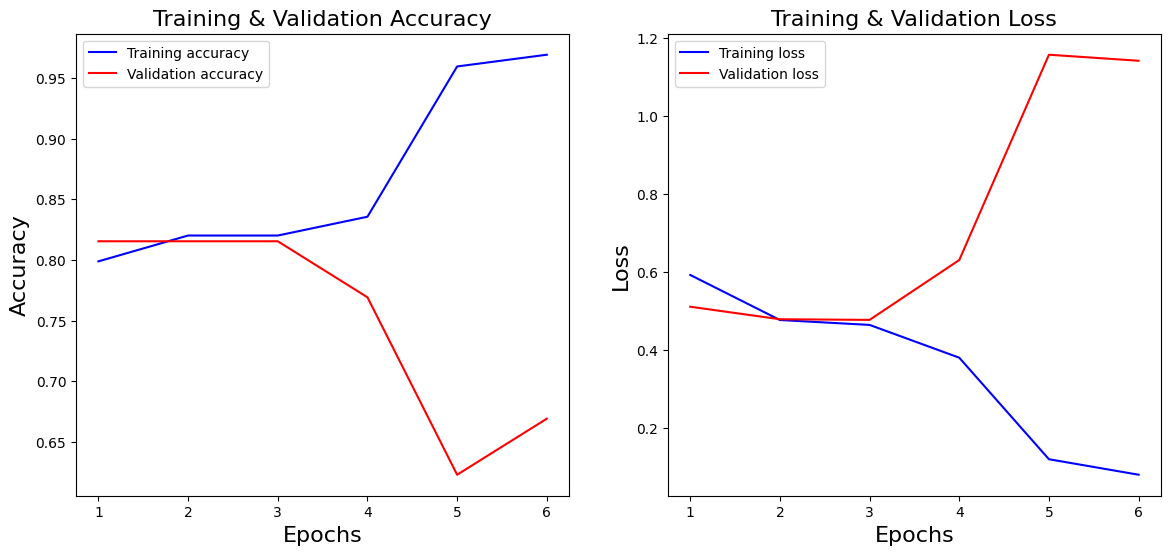

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Curva accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Curva loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Evaluar modelo

In [ ]:
# X_test = df_test['content'].tolist()  # Convertir los textos de prueba en una lista
# encoded_test = tokenizer.texts_to_sequences(X_test)  # Convertir los textos de prueba en secuencias de tokens
# encoded_test = pad_sequences(encoded_test, maxlen=MAX_LEN, padding='post')  # Aplicar padding a las secuencias de prueba

# # Asegurarse de que los datos de entrada y salida tengan el mismo número de muestras
# assert encoded_test.shape[0] == y_test_one_hot.shape[0], "El número de muestras en los datos de entrada y salida no coincide"

# # Evaluar el modelo
# loss, accuracy = model.evaluate(encoded_test, y_test_one_hot, batch_size=batch_size)
# Suponiendo que ya tienes tu modelo entrenado almacenado en la variable 'model'

# Evaluación del modelo en los datos de prueba

X_test = df_test['content'].tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')
loss, accuracy = model.evaluate(encoded_test,y_test, batch_size=batch_size)


ValueError: Data cardinality is ambiguous:
  x sizes: 129
  y sizes: 6
Make sure all arrays contain the same number of samples.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
y_pred = np.argmax(model.predict(encoded_test), axis=1)
print(y_pred[0:10])

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=LABELS))

5/5 [==============================] - 1s 56ms/step
[0 0 0 0 0 1 1 1 0 0]


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

Resultados de la macro

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)